In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#### Generating data

In [7]:
def Generate_Data(senario,parameter,category,year,initial_val, final_val, length):
    value = [int(abs(i)) for i in np.random.normal(initial_val, final_val, length)]
    items = len(value)
    Value1 = {"Scenario":[senario]*items, "Parameter":[parameter]*items, "Category":[category]*items,
              'Start_Value': value, "Year":[year]*items}
    All_Data = Value1
    return All_Data

In [8]:
SCENARIO = ["MODERATE",'AGGRESSIVE','22H1', 'NRG', 'LOW', 'HIGH']
PARAMETER = ['SUBS','HOUR_PER_DAY','MBPS','WIFI_OFFLOAD']
CATEGORY = ['AR-TECH','AR-EMB', 'VR-TECH', 'VR-EMB']
YEAR = [2024,2025]

In [9]:
ALL_DATA = []
for i in SCENARIO:
    for j in PARAMETER:
        for k in CATEGORY:
            for l in YEAR:
                value = [i,j,k, l]
                ALL_DATA.append(value)
                

In [25]:
initial_val = 3000
final_val = 30000
length = 1000
senario,parameter,category,year = ALL_DATA[1]
return_value = Generate_Data(senario,parameter,category,year,initial_val, final_val, length)
full_frame = pd.DataFrame(return_value)
for i in ALL_DATA[1:]:
    senario,parameter,category,year = i
    if parameter == 'SUBS':
        initial_val = 3000
        final_val = 30000
        length = 1000
        return_value = Generate_Data(senario,parameter,category,year,initial_val, final_val, length)
    elif parameter == 'HOURS_PER_DAY':
        initial_val = 1
        final_val = 24
        length = 1000
        return_value = Generate_Data(senario,parameter,category,year,initial_val, final_val, length)
    elif parameter == 'MBPS':
        initial_val = 20
        final_val = 120
        length = 1000
        return_value = Generate_Data(senario,parameter,category,year,initial_val, final_val, length)
    elif parameter == 'WIFI_OFFLOAD':
        initial_val = 92
        final_val = 99
        length = 1000
        return_value = Generate_Data(senario,parameter,category,year,initial_val, final_val, length)
    temp =  pd.DataFrame(return_value)
    table = full_frame.append(temp)
    full_frame = table
#table
full_frame

,Scenario,Parameter,Category,Start_Value,Year
0,MODERATE,SUBS,AR-TECH,28153,2025
1,MODERATE,SUBS,AR-TECH,2619,2025
2,MODERATE,SUBS,AR-TECH,88354,2025
3,MODERATE,SUBS,AR-TECH,430,2025
4,MODERATE,SUBS,AR-TECH,35657,2025
...,...,...,...,...,...
995,HIGH,WIFI_OFFLOAD,VR-EMB,193,2025
996,HIGH,WIFI_OFFLOAD,VR-EMB,66,2025
997,HIGH,WIFI_OFFLOAD,VR-EMB,115,2025
998,HIGH,WIFI_OFFLOAD,VR-EMB,102,2025


In [26]:
observation = full_frame[full_frame['Parameter'] == 'SUBS']
observation = observation[observation['Year'] == 2024].Start_Value

23905.346826086956

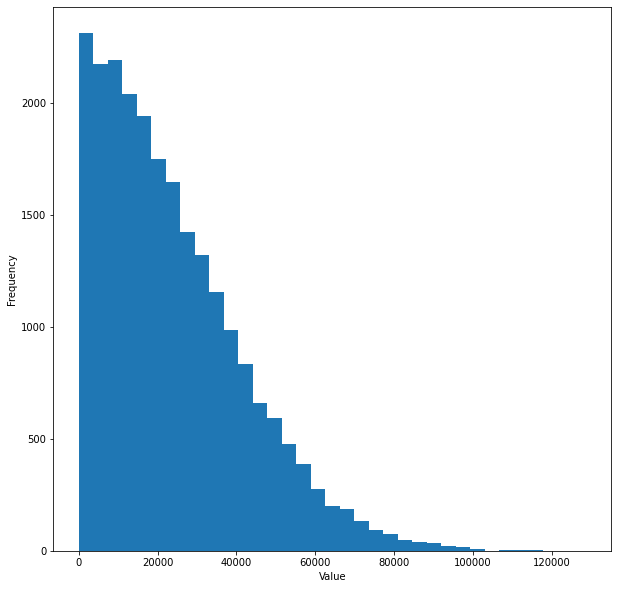

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist(observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
mu_obs=observation.mean()
mu_obs

In [30]:
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    if(x[1] <=0):
        return 0
    return 1


def manual_log_like_normal(x,data):
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))


def log_lik_normal(x,data):
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [32]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 500,observation,acceptance)

C:\Users\hp\AppData\Local\Temp\ipykernel_16244\2690719338.py:10: RuntimeWarning: invalid value encountered in log
  return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))
C:\Users\hp\AppData\Local\Temp\ipykernel_16244\2690719338.py:33: RuntimeWarning: divide by zero encountered in log
  if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):


(253, 2)

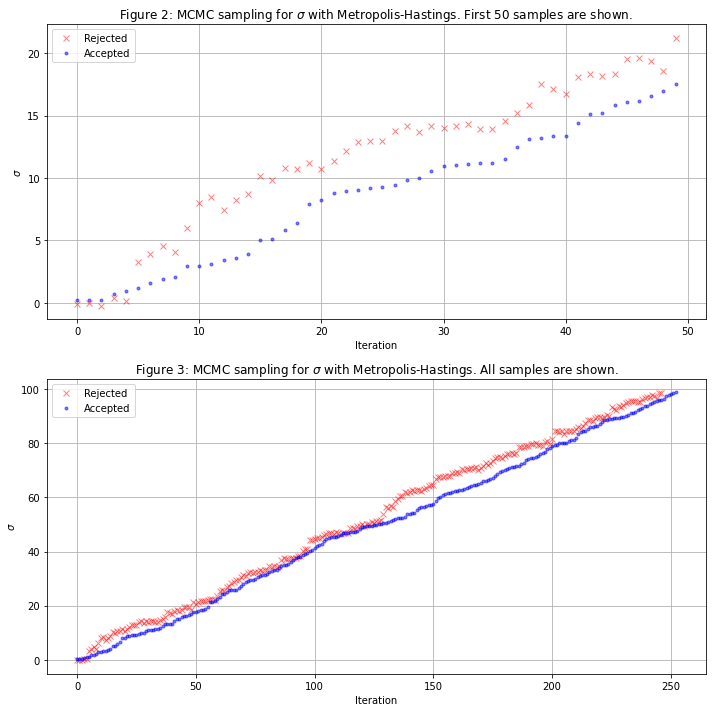

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: MCMC sampling for $\sigma$ with Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejected',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: MCMC sampling for $\sigma$ with Metropolis-Hastings. All samples are shown.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape